In [76]:
import hail as hl
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [11]:
phen='50'
batch='1'
n_chunks=300
variant_set='hm3'

# 300 chunks

In [44]:
gmt = hl.read_matrix_table('gs://nbaya/split/meta_split/ukb31063.'+variant_set+'_'+phen+'_gmt'+str(n_chunks)+'_batch_'+batch+'.mt') #used for n=150 and other phenotypes
gmt = gmt.add_col_index()
gmt = gmt.rename({'rsid':'SNP'})

In [45]:
gmt1 = gmt.annotate_cols(label='A')
gmt1 = gmt1.annotate_entries(w = 1/gmt1.standard_error **2)
gmt2 = gmt1.group_cols_by(gmt1.label).aggregate(unnorm_meta_beta=hl.agg.sum(gmt1.beta * gmt1.w),
                                            inv_se2 = hl.agg.sum(gmt1.w))
mt = gmt2.make_table()
mt = mt.annotate(x_w = mt['A.unnorm_meta_beta']/mt['A.inv_se2'])

In [60]:
gmt2.count()

2018-12-14 13:56:54 Hail: INFO: Coerced sorted dataset


(1089172, 1)

In [46]:
gmt1 = gmt1.key_rows_by('SNP')
mt = mt.key_by('SNP')
gmt1 = gmt1.annotate_rows(x_w = mt[gmt1.SNP]['x_w'])

In [50]:
gmt_test = gmt1.annotate_entries(x_w_ent = gmt1.x_w)

In [48]:
# gmt_test = gmt_test.group_cols_by(gmt_test.label).aggregate(Q_i = hl.agg.sum(gmt_test.w*(gmt_test.beta-gmt_test.x_w_ent)**2))

In [49]:
gmt_test.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    'label': str 
----------------------------------------
Row fields:
    'locus': locus<GRCh37> 
    'alleles': array<str> 
    'SNP': str 
    'varid': str 
    'x_w': float64 
----------------------------------------
Entry fields:
    'Q_i': float64 
----------------------------------------
Column key: ['label']
Row key: ['SNP']
----------------------------------------


In [51]:
gmt_test = gmt_test.annotate_rows(Q_j = hl.agg.sum(gmt_test.w*(gmt_test.beta-gmt_test.x_w_ent)**2))

In [76]:
gmt_test.rows().select('Q_j').write('gs://nbaya/split/cochrans_q.'+phen+'_batch_'+batch+'.ht')

2018-12-13 19:38:28 Hail: INFO: wrote 1089172 items in 1000 partitions


In [52]:
ht = gmt_test.rows().select('Q_j')

In [80]:
import matplotlib.pyplot as plt
import pandas as pd

In [82]:
ht.export('gs://nbaya/split/cochrans_q.'+phen+'_batch_'+batch+'.tsv.bgz')

2018-12-13 19:47:17 Hail: INFO: while writing:
    gs://nbaya/split/cochrans_q.50_batch_1.tsv.bgz
  merge time: 3.879s


In [53]:
Q = ht.Q_j.take(10891720)


2018-12-14 13:49:00 Hail: INFO: Ordering unsorted dataset with network shuffle
2018-12-14 13:49:29 Hail: INFO: Ordering unsorted dataset with network shuffle


Text(0.5,1,'title')

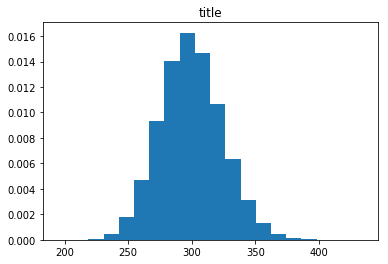

In [54]:
plt.hist(Q,20,density=True)
plt.title('title')

# 2 halves

In [61]:
gmt = hl.read_matrix_table('gs://nbaya/split/meta_split/ukb31063.'+variant_set+'_'+phen+'_gmt'+str(n_chunks)+'_batch_'+batch+'.mt') #used for n=150 and other phenotypes
gmt = gmt.add_col_index()
gmt = gmt.rename({'rsid':'SNP'})

In [66]:
pi = ['A']*int(n_chunks/2) + ['B']*int(n_chunks/2)
#    randstate = np.random.RandomState(i) #OPTION 1: seed with split number (used for 20160 batch1)
i = 1
seed_id = int(batch+str(i).zfill(4)) #OPTION 2: create a seed_id unique to every split
randstate = np.random.RandomState(seed_id) #OPTION 2: seed with seed_id
randstate.shuffle(pi)
gmt_shuf = gmt.annotate_cols(label = hl.literal(pi)[hl.int32(gmt.col_idx)])

In [67]:
gmt_shuf = gmt_shuf.group_cols_by(gmt_shuf.label).aggregate(meta_beta=hl.agg.sum(gmt_shuf.beta / gmt_shuf.standard_error ** 2)/hl.agg.sum(1 / gmt_shuf.standard_error ** 2),
                            meta_se = 1/hl.agg.sum(1 / gmt_shuf.standard_error ** 2))

In [69]:
gmt1 = gmt_shuf.annotate_cols(label_new='A')
gmt1 = gmt1.annotate_entries(w = 1/gmt1.meta_se**2)
gmt2 = gmt1.group_cols_by(gmt1.label_new).aggregate(unnorm_meta_beta=hl.agg.sum(gmt1.meta_beta * gmt1.w),
                                            inv_se2 = hl.agg.sum(gmt1.w))
mt = gmt2.make_table()
mt = mt.annotate(x_w = mt['A.unnorm_meta_beta']/mt['A.inv_se2'])

In [70]:
gmt1 = gmt1.key_rows_by('SNP')
mt = mt.key_by('SNP')
gmt1 = gmt1.annotate_rows(x_w = mt[gmt1.SNP]['x_w'])

In [72]:
gmt_test = gmt1.annotate_entries(x_w_ent = gmt1.x_w)
gmt_test = gmt_test.annotate_rows(Q_j = hl.agg.sum(gmt_test.w*(gmt_test.meta_beta-gmt_test.x_w_ent)**2))

In [73]:
ht = gmt_test.rows().select('Q_j')

In [74]:
Q = ht.Q_j.take(10891720)

2018-12-14 14:06:06 Hail: INFO: Ordering unsorted dataset with network shuffle
2018-12-14 14:06:35 Hail: INFO: Ordering unsorted dataset with network shuffle


Text(0.5,1,'title')

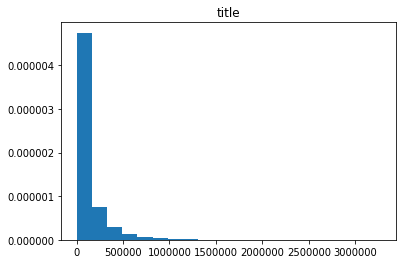

In [75]:
plt.hist(Q,20,density=True)
plt.title('title')

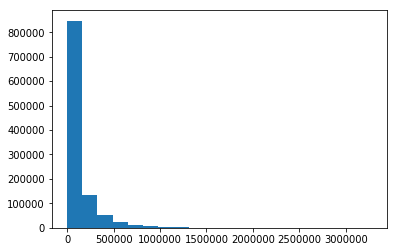

In [104]:
fig, ax = plt.subplots(1,1)
df=1.5
# x = np.linspace(stats.chi2.ppf(0.0001, df),stats.chi2.ppf(0.9999, df), 1000)
# ax.plot(x, stats.chi2.pdf(x, df),
#         'r-', lw=5, alpha=0.6, label='chi2 pdf')
hist = ax.hist(Q,20,density=False)


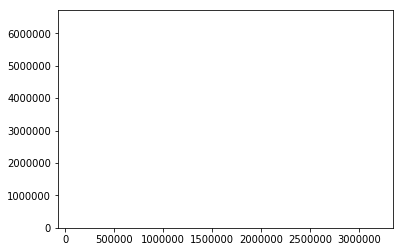

In [151]:
x = (hist[1][1:] + hist[1][:-1]) / 2
p1 = plt.bar(x,2*x)
plt.show()
# ax.show()

In [153]:
ht.export('gs://nbaya/split/cochrans_q.'+phen+'_batch_'+batch+'_split.tsv.bgz')

2018-12-14 14:37:29 Hail: INFO: Ordering unsorted dataset with network shuffle
2018-12-14 14:37:57 Hail: INFO: Ordering unsorted dataset with network shuffle
2018-12-14 14:39:25 Hail: INFO: while writing:
    gs://nbaya/split/cochrans_q.50_batch_1_split.tsv.bgz
  merge time: 4.292s


<BarContainer object of 5 artists>

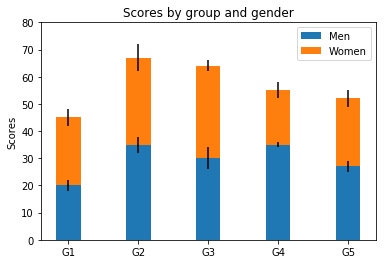

In [152]:
N = 5
menMeans = (20, 35, 30, 35, 27)
womenMeans = (25, 32, 34, 20, 25)
menStd = (2, 3, 4, 1, 2)
womenStd = (3, 5, 2, 3, 3)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, menMeans, width, yerr=menStd)
p2 = plt.bar(ind, womenMeans, width,
             bottom=menMeans, yerr=womenStd)

plt.ylabel('Scores')
plt.title('Scores by group and gender')
plt.xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Men', 'Women'))

p1